In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

In [7]:
test = pd.read_csv('../test_data.csv')
train = pd.read_csv('../train_data.csv')

# Clean data

In [8]:
#clean data
test = test.dropna()
train = train.dropna()
#log the land area
test['LANDAREA'] = np.log(test['LANDAREA'])
train['LANDAREA'] = np.log(train['LANDAREA'])


# OUTCOME
test_y = test['LN_PRICE']
train_y = train['LN_PRICE']
# PREDICTORS
test_x = test[['CNDTN','ROOMS','LANDAREA']]
train_x = train[['CNDTN','ROOMS','LANDAREA']]

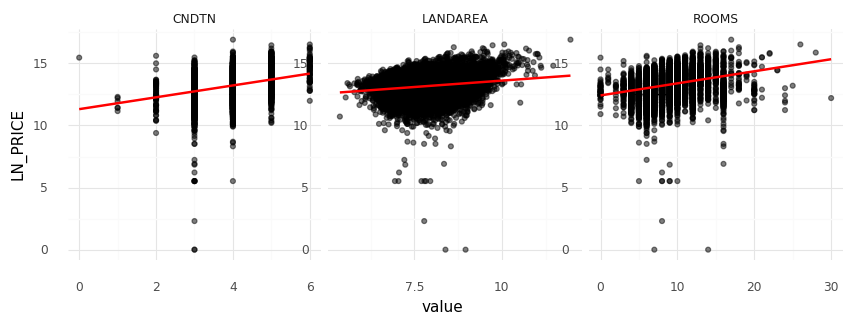

<ggplot: (84410419197)>

In [9]:
#look at shape
D = train_x.copy()
D['LN_PRICE'] = train_y

(
    ggplot(D.melt(id_vars=["LN_PRICE"]),
           aes(x="value",y="LN_PRICE"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)

# Pre-Process

In [10]:
#scale data 
scaler = pp.MinMaxScaler()
col_namestr = list(train_x)
train_x = scaler.fit_transform(train_x)
# Convert back into data frame
train_x = pd.DataFrame(train_x,columns=col_namestr)

train_x
#for some reason this scaling affects linear relationship when graphed again,
#  I will be ignoring this since that should not be occuring

,CNDTN,ROOMS,LANDAREA
0,0.833333,0.300000,0.354963
1,0.500000,0.300000,0.546214
2,0.500000,0.366667,0.345348
3,0.666667,0.233333,0.365790
4,0.666667,0.233333,0.279556
...,...,...,...
24993,0.500000,0.166667,0.144743
24994,0.666667,0.233333,0.292711
24995,0.666667,0.300000,0.283199
24996,0.666667,0.200000,0.213070


In [11]:
fold_generator = KFold(n_splits=6, shuffle=True,random_state=112)
metrics = ["neg_mean_squared_error"]
#linear model
lm_scores = cross_validate(LM(),train_x,train_y, cv = fold_generator, scoring = metrics)
#knn model
knn_scores = cross_validate(KNN(),train_x,train_y, cv = fold_generator, scoring = metrics)
#decision tree
dt_scores = cross_validate(DTree(),train_x,train_y, cv = fold_generator, scoring = metrics)
#bagging
bag_scores = cross_validate(Bag(),train_x,train_y, cv = fold_generator, scoring = metrics)
#random forests
rf_scores = cross_validate(RF(),train_x,train_y, cv = fold_generator, scoring = metrics)

In [12]:
#collect all scores
collect_scores = \
dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")
collect_scores

,Model,MSE
0,lm,0.559944
1,lm,0.479540
2,lm,0.464454
3,lm,0.464901
4,lm,0.483157
5,lm,0.514354
6,knn,0.586864
7,knn,0.510924
8,knn,0.503266
9,knn,0.499787


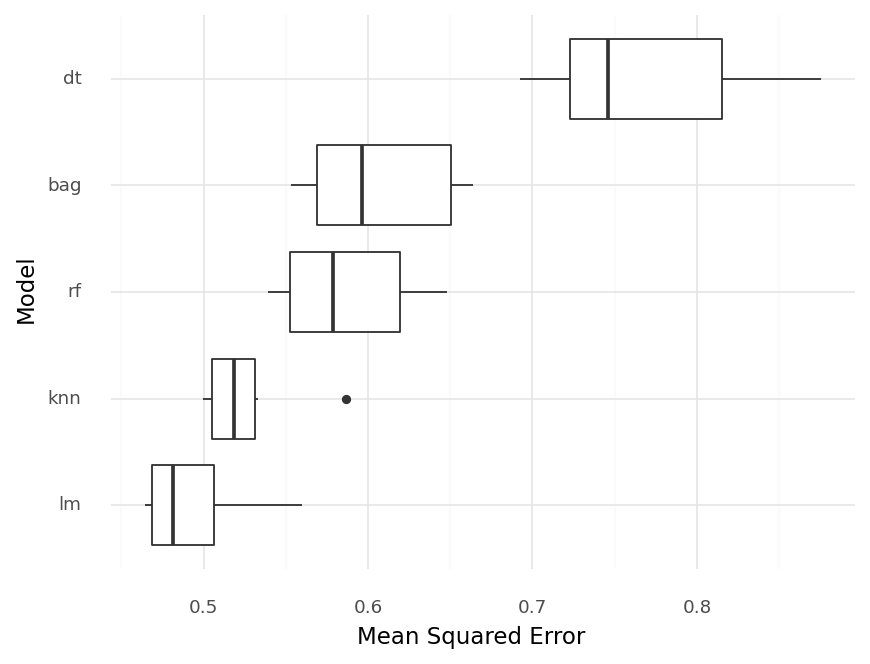

<ggplot: (84404174174)>

In [13]:
# Get the order of the models
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

# Plot
(
    ggplot(collect_scores,
          aes(x="Model",y="MSE")) +
    geom_boxplot() +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error") +
    coord_flip() +
    theme_minimal() +
    theme(dpi=150)
)
#prior to tuning, linear model appears to be best fit 

In [14]:
#tune the knn
knn_tune_params = {'n_neighbors':[10, 25, 35, 50, 75, 100, 250, 380]}
tune_knn = GridSearchCV(KNN(),knn_tune_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)
tune_knn.fit(train_x,train_y)
print(tune_knn.best_params_,tune_knn.best_score_)

{'n_neighbors': 75} -0.4519142431169733


In [15]:
#tune decision tree
tune_dt = GridSearchCV(DTree(),{'max_depth':[i for i in range(10)]},
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)
tune_dt.fit(train_x,train_y)
print(tune_dt.best_params_,tune_dt.best_score_)

{'max_depth': 5} -0.4701677897125216


In [16]:
#tune random forest
rf_params = {'max_depth':[1,2,3],
             'n_estimators':[100,500,1000],
              'max_features': [1,2]} # Only have three total. 
tune_rf = GridSearchCV(RF(),rf_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)
tune_rf.fit(train_x,train_y) 
print(tune_rf.best_params_,tune_rf.best_score_)

{'max_depth': 3, 'max_features': 2, 'n_estimators': 500} -0.4804810847315218


# pipe together

In [18]:
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['CNDTN','ROOMS','LANDAREA'])])

pipe = Pipeline(steps=[('pre_process', preprocess),
                ('model',None)])

search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[35,50,75,250,380]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[3,5,6,8]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]

search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=6, random_state=112, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['CNDTN',
                                                                          'ROOMS',
                                                                          'LANDAREA'])])),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor(n_neighbors=75)],
                          'model__n_neighbors': [35, 50, 75, 250, 380]},
                         {'model': [DecisionTreeRegressor()],
                          'model__max_depth': [3, 5, 6, 8]},
                         {'model': [Bagging

Mean squared error = 4.041341704870495
-5.668825022409265


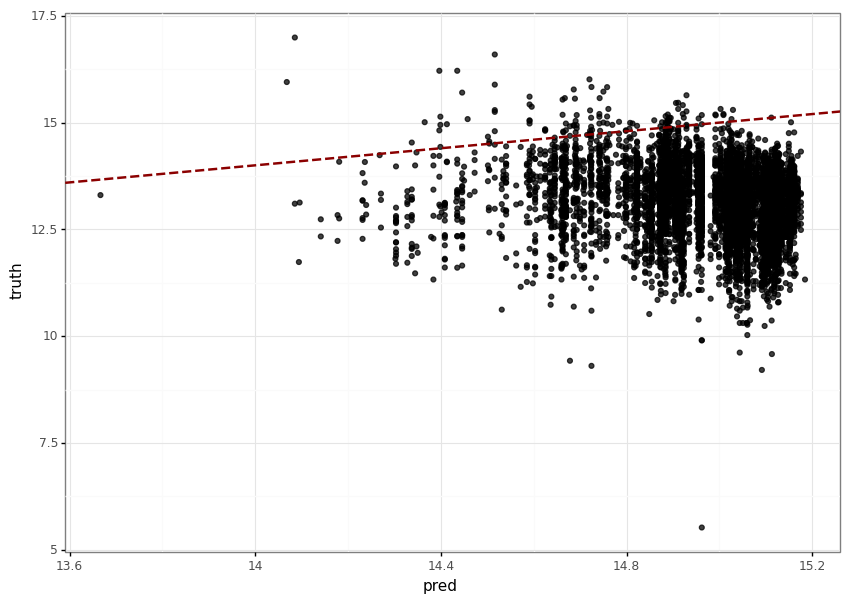

<ggplot: (84290001911)>

In [20]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_x)
print("Mean squared error =", m.mean_squared_error(test_y,pred_y))
print(m.r2_score(test_y,pred_y))
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)